# RNN_driven_strategy

__Description__

...

__Journal of negative results__

...

In [1]:
# imports
%run ../modules/pnl_module.ipynb
%run ../modules/objectives_module.ipynb
%run ../modules/tools_module.ipynb

In [2]:
import pandas as pd
import datetime
import numpy.ma as ma
import tqdm
import glob

### Data prepare

In [3]:
gics_sectors_data = pd.read_csv('../data/spx_dataset/gics_sectors.csv', usecols=['ISIN', 'sector'], index_col='ISIN')

In [4]:
sectors_data = pd.read_csv('../data/spx_dataset/sectors.csv', usecols=['ISIN', 'sector'], index_col='ISIN')

In [5]:
all_sectors = set(sectors_data.sector)
' '.join(map(str, all_sectors))

'nan Diversified Consumer Communications Industrial Technology Financial Utilities BasicMaterials Energy'

In [6]:
all_gics_sectors = set(gics_sectors_data.sector)
' '.join(map(str, all_gics_sectors))

'nan TelecommunicationServices Industrials HealthCare ConsumerDiscretionary RealEstate Materials Financials InformationTechnology Utilities ConsumerStaples Energy'

In [213]:
# params
sector_need = 'GICS_ConsumerStaples'

FAST_PERIOD = 26
SLOW_PERIOD = 46
FUTRET_WINDOW = 50
START_DATE = datetime.datetime(2006, 1, 1)

In [214]:
if sector_need[:4] == 'GICS':
    sector = sector_need[5:]
    sector_subset = [sym for sym in sectors_data.index if gics_sectors_data['sector'].loc[sym] == sector] 
else:
    sector = sector_need
    sector_subset = [sym for sym in sectors_data.index if sectors_data['sector'].loc[sym] == sector] 

In [215]:
data_path = '../data/spx_dataset/{}.csv'
args = {'parse_dates' : ['Date'], 'index_col' : 'Date', 'usecols' : (['Date'] + sector_subset)}
tickers = pd.read_csv(data_path.format('un_spx_daily_nonadjusted_close'), **args).columns

In [216]:
un_returns, un_a_pct_returns, un_na_price, in_spx_mask, un_a_price, si_factor, ra_factor, frac_factor, div_yields =\
        map(lambda filename:\
        read_data(filename, args, start_idx=START_DATE),\
        map(lambda s: data_path.format(s), ['un_spx_adjusted_returns', 'un_spx_adjusted_pct_returns', \
                                            'un_spx_daily_nonadjusted_close', 'in_spx_mask',\
                                            'un_spx_daily_adjusted_close',\
         'Features/SI_FACTOR', 'Features/RA_FACTOR', 'Features/FRAC_FACTOR', 'Features/un_spx_div_yields']))

print('Shapes: {}, {}, {}, {}, {}, {}, {}, {}'.format(un_returns.shape, un_na_price.shape, un_a_price.shape,\
                in_spx_mask.shape, ra_factor.shape, si_factor.shape, frac_factor.shape, div_yields.shape))

Shapes: (2835, 44), (2835, 44), (2835, 44), (2835, 44), (2835, 44), (2835, 44), (2835, 44), (2835, 44)


In [217]:
div_yields[np.isnan(div_yields)] = 0.

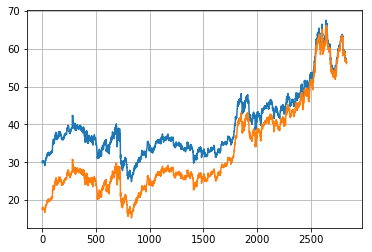

In [218]:

plt.figure()
plt.grid()
idx = np.random.randint(0, un_na_price.shape[1])
plt.plot(un_na_price[:, idx])
plt.plot(un_a_price[:, idx])


In [219]:
spy_pct_returns = read_data(data_path.format('spy_adjusted_percent_returns'), {'parse_dates' : ['Date'], 'index_col' : 'Date'}, START_DATE)
print('Shape: {}'.format(spy_pct_returns.shape))

Shape: (2835, 1)


In [220]:
"""
recs_files = glob.glob('../data/spx_dataset/Features/RA_recs/*.csv')
recs_labels = list(map(lambda s: s[37:-4], recs_files))
recs_features = {}
for lab, filename in zip(recs_labels, recs_files):
    recs_features[lab] = read_data(filename, args, start_idx=START_DATE)
"""

"\nrecs_files = glob.glob('../data/spx_dataset/Features/RA_recs/*.csv')\nrecs_labels = list(map(lambda s: s[37:-4], recs_files))\nrecs_features = {}\nfor lab, filename in zip(recs_labels, recs_files):\n    recs_features[lab] = read_data(filename, args, start_idx=START_DATE)\n"

In [221]:
mask = (np.isfinite(frac_factor) * \
        np.isfinite(si_factor) * np.isfinite(ra_factor) *\
        (in_spx_mask==1) * np.isfinite(un_na_price)).astype('bool')

anti_mask = (1-mask).astype('bool')

In [222]:
un_na_price[np.isnan(un_na_price)]=10**6
un_returns[np.isnan(un_returns)]=0

# fill factors with nan under mask
ra_factor[anti_mask]=np.nan
si_factor[anti_mask]=np.nan
div_yields[anti_mask] = np.nan
frac_factor[anti_mask] = np.nan

In [223]:
"""
for lab in recs_labels:
    recs_features[lab][anti_mask] = np.nan
"""

'\nfor lab in recs_labels:\n    recs_features[lab][anti_mask] = np.nan\n'

In [224]:
"""
rec_labels_dict = pd.read_csv('../data/spx_dataset/Features/recs_labels_dict.csv', sep=';')
buy_labels = [lab.strip() for lab in list(rec_labels_dict['BUY'].dropna())]
sell_labels = [lab.strip() for lab in list(rec_labels_dict['SELL'].dropna())]
neutral_labels = [lab.strip() for lab in recs_labels if lab not in buy_labels and lab not in sell_labels]
"""

"\nrec_labels_dict = pd.read_csv('../data/spx_dataset/Features/recs_labels_dict.csv', sep=';')\nbuy_labels = [lab.strip() for lab in list(rec_labels_dict['BUY'].dropna())]\nsell_labels = [lab.strip() for lab in list(rec_labels_dict['SELL'].dropna())]\nneutral_labels = [lab.strip() for lab in recs_labels if lab not in buy_labels and lab not in sell_labels]\n"

In [225]:
"""
buy_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in buy_labels], axis=-1), axis=-1)
sell_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in sell_labels], axis=-1), axis=-1)
neutral_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in neutral_labels], axis=-1), axis=-1)
"""

'\nbuy_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in buy_labels], axis=-1), axis=-1)\nsell_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in sell_labels], axis=-1), axis=-1)\nneutral_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in neutral_labels], axis=-1), axis=-1)\n'

In [226]:
"""
buy_rec_factor[anti_mask] = np.nan
sell_rec_factor[anti_mask] = np.nan
neutral_rec_factor[anti_mask] = np.nan
"""

'\nbuy_rec_factor[anti_mask] = np.nan\nsell_rec_factor[anti_mask] = np.nan\nneutral_rec_factor[anti_mask] = np.nan\n'

In [227]:
#div_yields, frac_factor = map(relative_scaler, (div_yields, frac_factor))

In [228]:
features_tensor = np.stack([ra_factor, si_factor, div_yields, frac_factor], axis=-1)
#features_tensor2 = np.stack([buy_rec_factor, sell_rec_factor, neutral_rec_factor], axis=-1)
#features_tensor2 /= (np.nansum(features_tensor, axis=-1, keepdims=True))
#features_tensor = np.concatenate([features_tensor, sectors_factor], axis=-1)
#features_tensor = np.concatenate([features_tensor, features_tensor2[:, :, :-1]], axis=-1)

In [229]:
features_tensor = np.stack([ra_factor, si_factor, div_yields, frac_factor], axis=-1)
print(features_tensor.shape)
#features_tensor = np.concatenate([features_tensor, sectors_factor], axis=-1)

(2835, 44, 4)


In [230]:
print(features_tensor.shape)

(2835, 44, 4)


In [231]:
target = weighted_futret(un_a_pct_returns, FUTRET_WINDOW)
target[anti_mask]=np.nan

In [232]:
top_bottom_size = 20
print('Sector {}: {}'.format(sector_need[0], top_bottom_size))

Sector G: 20


In [233]:
np.log(target.shape[1]) 

3.784189633918261

### Model (ranking)

In [234]:
OFFSET = FUTRET_WINDOW
WINDOW_TRAIN = 1000
RETRAIN_FREQ = 25
SAMPLING_SIZE = 20 #round(target.shape[0]/3, 0)

In [235]:
features_tensor.shape, target.shape

((2835, 44, 4), (2835, 44))

In [236]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [237]:
def get_ranker(t, transformer=None):
    X, y = dinamic_train_cut(features_tensor, target, t, WINDOW_TRAIN, OFFSET)
    X_train, y_train = ranker_unpack(X, y, SAMPLING_SIZE)
    #print(X_train)
    if transformer:
        X_train = transformer.fit_transform(X_train)
    #mod = SVC(max_iter = 1000).fit(X_train, y_train)
    mod = LogisticRegression(C=1., penalty='l2').fit(X_train, y_train)
    return mod.decision_function, transformer.transform

In [238]:


Q = np.empty(ra_factor.shape)
Q[:] = np.nan
start_t = OFFSET + WINDOW_TRAIN - 1
decision_fun, transform = get_ranker(start_t, PolynomialFeatures(1, False, False))
#decision_fun, transform = get_ranker(start_t, PolynomialFeatures(2))
for i in tqdm.tqdm(range(start_t, Q.shape[0])):
    if i % RETRAIN_FREQ == 0:
        decision_fun, transform = get_ranker(i, PolynomialFeatures(1, False, False))
        #decision_fun, transform = get_ranker(i, PolynomialFeatures(2))
    new_x = features_tensor[i, :, :]
    finite_idxs = np.where(np.isfinite(new_x).all(axis=1))[0]
    try:
        Q[i, finite_idxs] = decision_fun(transform(features_tensor[i, finite_idxs, :]) )  
    except:
        continue
        


100%|█████████████████████████████████████| 1786/1786 [00:15<00:00, 114.61it/s]


In [239]:
Q = np.where(np.isnan(Q), ma.array(Q, mask=np.isnan(Q)).mean(axis=1, keepdims=True), Q)  
#Q = np.where(np.isnan(ra_factor), ma.array(ra_factor, mask=np.isnan(ra_factor)).mean(axis=1, keepdims=True), ra_factor)  

### Backtest (ranking approach)

In [240]:
Q = Q[start_t:, :]
if un_na_price.shape[0] != Q.shape[0]:
    un_na_price, un_returns, mask, anti_mask = map(lambda df: df[start_t:,:], (un_na_price, un_returns, mask, anti_mask))

In [241]:
Q.shape, un_na_price.shape, mask.shape

((1786, 44), (1786, 44), (1786, 44))

In [242]:
_buying_power.set_value(10. ** 6)
_commis_per_share.set_value(0.01)
_nb_top.set_value(5)
_nb_bottom.set_value(5)

In [243]:
#shares = np.maximum(quality_to_share_robust_fun(Q, un_na_price, mask), 0)
shares = quality_to_share_robust_fun(Q, un_na_price, mask)
#shares = quality_to_share_soft_fun(Q, un_na_price, mask)
shares = shares_norebalance(shares)

In [244]:
long_pos_count = (shares > 0).astype('float32').sum(axis=1)
short_pos_count = (shares < 0).astype('float32').sum(axis=1)
long_check = np.logical_or(long_pos_count == 0, long_pos_count == _nb_top.get_value()).all()
short_check = np.logical_or(short_pos_count == 0, short_pos_count == _nb_bottom.get_value()).all()
print('Robust matrix check pass: {}, {}'.format(long_check, short_check))

Robust matrix check pass: False, False


In [245]:
Q_ = np.copy(Q)
Q_[anti_mask] = np.nan

C:\Users\evgeniy.tumanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


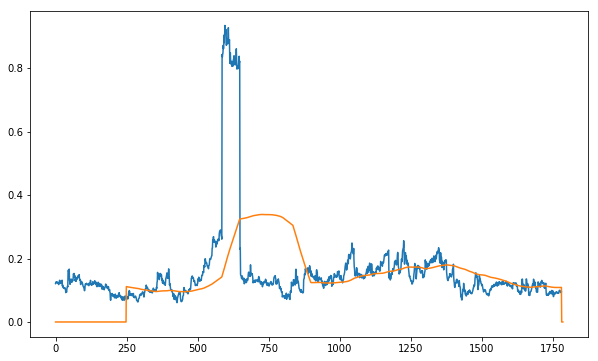

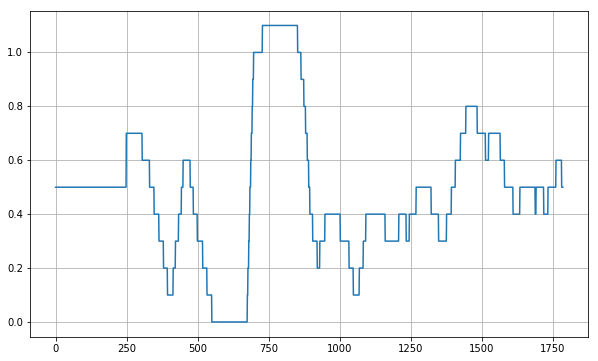

In [246]:


plt.figure(figsize=(10,6))
qual_range = np.nanstd(Q_, axis=1)
qual_rolling_mean = np.nan_to_num(numpy_matrix_sma(qual_range.reshape(-1, 1), 250)).ravel()
qual_rolling_fast_mean = np.nan_to_num(numpy_matrix_sma(qual_range.reshape(-1, 1), 50)).ravel()

plt.plot(qual_range)
plt.plot(qual_rolling_mean)
conf = ((qual_rolling_fast_mean - qual_rolling_mean) / qual_rolling_mean)
conf[np.isinf(conf)] = 0
conf[np.isnan(conf)] = 0
conf = np.maximum(0.5 - np.minimum(conf, 0.5), 0)
conf = np.floor(conf * 10)/10

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(conf)


In [247]:
shares2 = shares * conf.reshape(-1, 1)

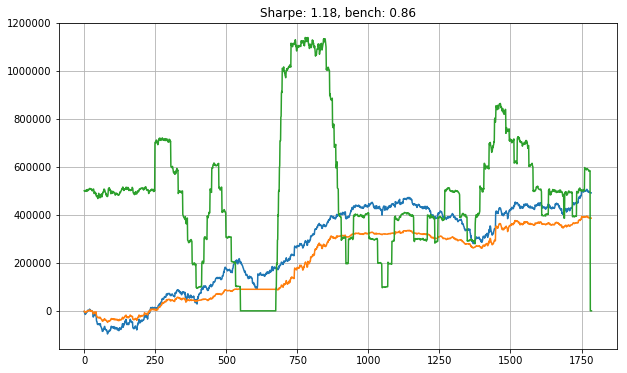

In [248]:
strategy_returns_arr = strategy_returns_fun(shares, un_returns)
strategy_returns_arr2 = strategy_returns_fun(shares2, un_returns)
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(strategy_returns_arr.cumsum())
plt.plot(strategy_returns_arr2.cumsum())

mval = market_value_fun(shares, un_na_price)
mval2 = market_value_fun(shares2, un_na_price)

#plt.plot(1000000 * qual_range)

#plt.plot(mval)
plt.plot(mval2)
plt.title('Sharpe: {}, bench: {}'.format(round(sharpe(strategy_returns_arr2), 2),\
                                        round(sharpe(strategy_returns_arr), 2)))

In [249]:
try:
    len(by_sector_ranking)
except NameError:
    by_sector_ranking = {}

In [250]:
by_sector_ranking[sector_need] = strategy_returns_arr
by_sector_ranking[sector_need+'with_conf'] = strategy_returns_arr2
by_sector_ranking[sector_need + 'mval'] = mval2

In [251]:
by_sector_ranking.keys()

dict_keys(['Industrial', 'Industrialwith_conf', 'Industrialmval', 'Communications', 'Communicationswith_conf', 'Communicationsmval', 'Consumer', 'Consumerwith_conf', 'Consumermval', 'GICS_HealthCare', 'GICS_HealthCarewith_conf', 'GICS_HealthCaremval', 'GICS_ConsumerDiscretionary', 'GICS_ConsumerDiscretionarywith_conf', 'GICS_ConsumerDiscretionarymval', 'GICS_ConsumerStaples', 'GICS_ConsumerStapleswith_conf', 'GICS_ConsumerStaplesmval'])

In [265]:
sector_sum = ['Consumer', 'Industrial', 'Communications' ,\
              'GICS_HealthCare', 'GICS_ConsumerDiscretionary', 'GICS_ConsumerStaples']

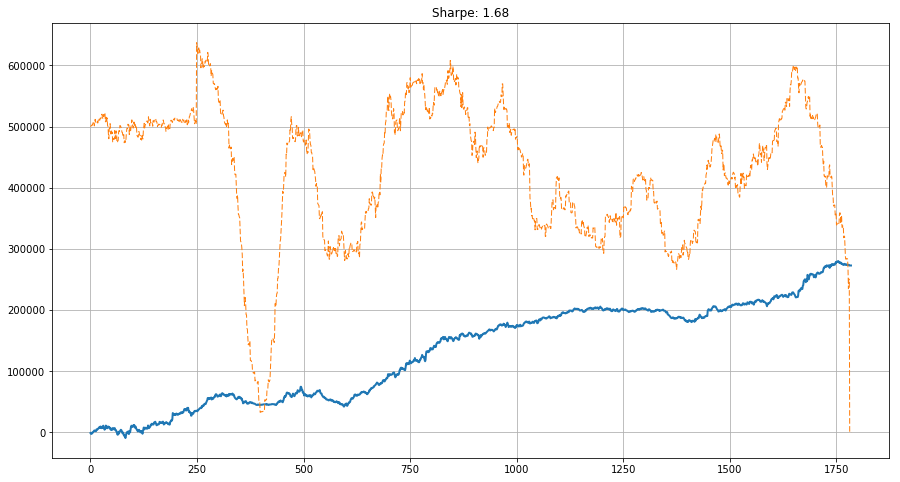

In [269]:
plt.figure(figsize=(15, 8))
plt.grid()

sum_pl = np.copy(by_sector_ranking[sector_sum[0] + 'with_conf'])
sum_mval = np.copy(by_sector_ranking[sector_sum[0] + 'mval'])
#plt.plot(by_sector_ranking[sector_sum[0] + 'with_conf'].cumsum())

for k in sector_sum[1:]:
    sum_pl += by_sector_ranking[k + 'with_conf']
    sum_mval += by_sector_ranking[k + 'mval']
    #plt.plot(by_sector_ranking[k + 'with_conf'].cumsum())


plt.plot((sum_pl / len(sector_sum)).cumsum()[0:], linewidth=2)

plt.plot((sum_mval[0:] / len(sector_sum)), '--', linewidth=1)

plt.title('Sharpe: {}'.format(round(sharpe(sum_pl), 2)))


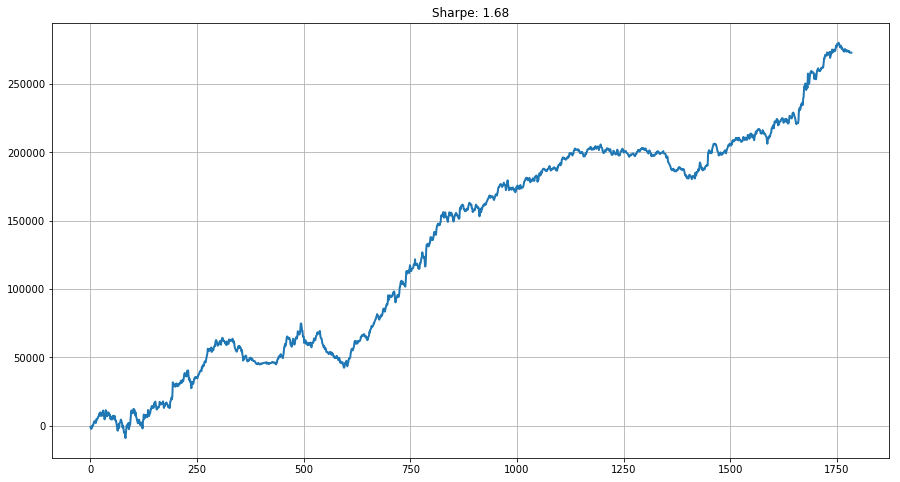

In [271]:
plt.figure(figsize=(15, 8))
plt.grid()


plt.plot((sum_pl / len(sector_sum)).cumsum()[0:], linewidth=2)

plt.title('Sharpe: {}'.format(round(sharpe(sum_pl), 2)))
